In [52]:
import arviz as az
import numpy as np
import pymc as pm
import pymc.dims as pmd

features = ['x', 'y']
coords = {'locations':['oslo', 'bergen'],
          'years': [2022, 2023, 2024],
          'features': features,
          'f2': features,
          }

with pm.Model(coords=coords) as model:
    sd_dist = pm.Exponential.dist(1.0, size=len(coords['features']))
    cholesky,*_ = pm.LKJCholeskyCov('cholesky_raw', eta=2, n=len(coords['features']), sd_dist=sd_dist,compute_corr=True)
    print(cholesky.type)
    chol = pmd.as_xtensor(cholesky, dims=('features', 'f2'), name='cholesky')

    arange = pmd.as_xtensor(np.arange(len(features)), dims=('features',))
    h_mu = pmd.Normal('h_mu', mu=arange, sigma=1, dims=('features',))
    mu = pmd.MvNormal('mu', mu=h_mu, chol=chol, core_dims=('features', 'f2'), dims=('locations', 'features'))
    dummy  = pmd.Normal('dummy', mu=arange, sigma=1, dims=('locations','features',))
    mu2 = pm.MvNormal('mu2', mu=h_mu.values, chol=cholesky, shape=(len(coords['locations']), len(features)), dims=('locations', 'features'))
    mu3 = pm.Deterministic('tmp', mu+dummy)
    #mu3 =pmd.as_xtensor(mu2, dims=('locations','features'))
    idata = pm.sample_prior_predictive()



Matrix(float64, shape=(2, 2))


Sampling: [cholesky_raw, dummy, h_mu, mu, mu2]


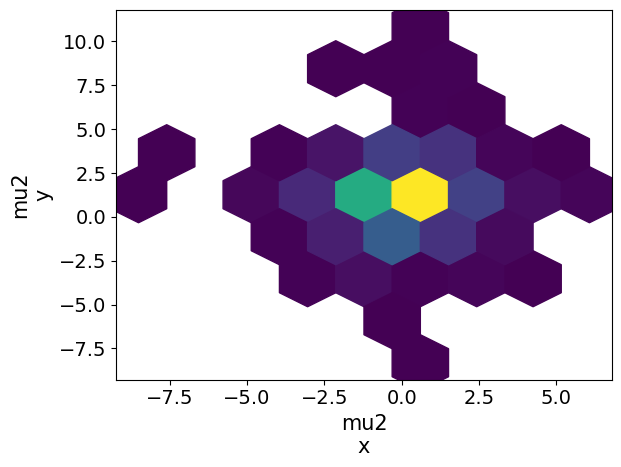

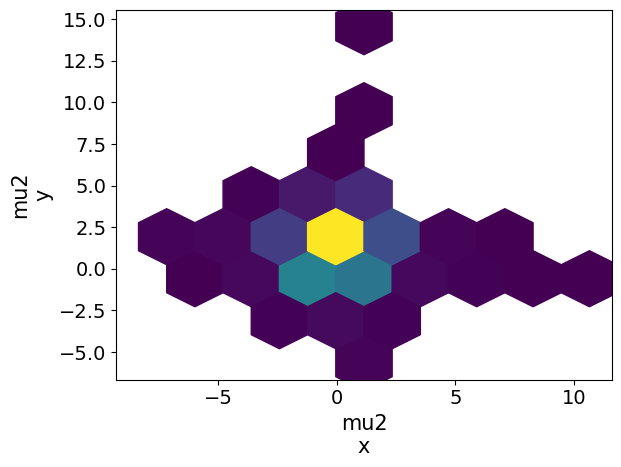

In [46]:
#z.plot_posterior(idata, var_names=['mu'])
#az.plot_pair(idata, group='prior', var_names=['mu'], kind='hexbin')
for location in coords['locations']:
    az.plot_pair(idata.sel(locations=location), group='prior', var_names=['mu2'], kind='hexbin')

#print(idata.prior)
#print(idata.prior['mu'].stack(samples=('chain', 'draw')).values)



#data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], size=1000)
